#Techniques in High Performance Computing Coursework 1

In [ ]:
#Import packages
import numpy as np
import numba
import threading
import multiprocessing

##Comparison of starting code and Numpy dot product A @ B
In this section we time the Numpt dot product on matricies of dimension 50x50 upto 1000x1000, increaseing by 50 rows and columns each iteration. We store all of these results in an array and use them as a benchmark when comparing the performance of the matrix_prod function and the other adaptation which follow.

In [ ]:
def matrix_product(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b."""
    m = mat_a.shape[0] #Row dim of mat_a
    n = mat_b.shape[1] #Column dim of mat_b

    assert(mat_a.shape[1] == mat_b.shape[0]) #Check rows of mat_a and cols of mat_b have the same dim

    ncol = mat_a.shape[1] #Define col dim of new matrix

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in range(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

a = np.random.randn(10, 10)
b = np.random.randn(10, 10)

c_actual = matrix_product(a, b)
c_expected = a @ b

error = np.linalg.norm(c_actual - c_expected) / np.linalg.norm(c_expected)
print(f"The error is {error}.")

The error is 1.0334823904886105e-16.


The matrix_prod function eviddently produces a matrix vequal to that of the numpt dot product to an accuracy of 16 decimal places.

Below I define all matrix dimensions I wish to consider and create storage arrays for the matrix product function, named "time_for_loop". This name is chosen to signify that it is an implementation using nested for loops.

Next I loop over every dimension, refining a new pair of randon matricies and recording only the result of their computation. The results is appended to the arrays defined above. Note that as the size of the matrix increases the number of loops carried out decreases automatically to reduce the total load. Otherwise it would take a very long time to run matrix_prod for larger matrix sizes. I will also omit the larger dimension from the naive computation due to the amount of time taken. 

Please note that due to the slowness of the matrix_product function I will only demonstrate it on a subset of matricies between 10x10 and 100x100. It will be clear that from this alone is is outperformed by every other implementation attempted.

In [ ]:
mini_dim = np.arange(10,110,10, dtype = int).astype(np.int64)
mini_dim

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [ ]:
#Record time for naive matrix product
time_for_loop_mini = []
time_dot_prod_mini = []
for i in mini_dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o matrix_product(a, b)
  time_for_loop_mini.append(dummy.best)

for i in mini_dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o a @ b
  time_dot_prod_mini.append(dummy.best)

1000 loops, best of 5: 957 µs per loop
100 loops, best of 5: 7.52 ms per loop
10 loops, best of 5: 24.6 ms per loop
10 loops, best of 5: 60 ms per loop
10 loops, best of 5: 115 ms per loop
1 loop, best of 5: 197 ms per loop
1 loop, best of 5: 316 ms per loop
1 loop, best of 5: 470 ms per loop
1 loop, best of 5: 679 ms per loop
1 loop, best of 5: 919 ms per loop
The slowest run took 17.31 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 1.95 µs per loop
The slowest run took 7.16 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 2.9 µs per loop
The slowest run took 6.06 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 5.71 µs per loop
The slowest run took 14.14 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 8.62 µs per 

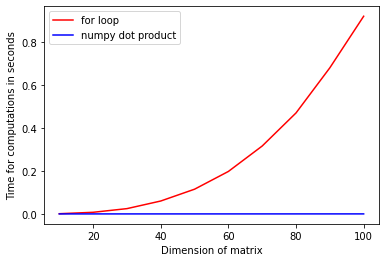

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

X = mini_dim

plt.plot(X,time_for_loop_mini,'-r',label = 'for loop')
plt.plot(X,time_dot_prod_mini,'-b',label = 'numpy dot product')
plt.xlabel('Dimension of matrix')
plt.ylabel('Time for computations in seconds')
plt.legend(loc="best")
plt.show()

Clearly, even for small dimensions (up to 100x100) the naive function matrix_product is remarkably slow. To use this function to compute a 100x100 matrix takes considerably longer than computing the product of 1000x1000 matricies when even simple inprovements are implemented, as will be seen later.

In [ ]:
dim = np.arange(50,1050,50)

In [ ]:
#Record time for numpy dot product, using matricies of dim 50x50, 100x100, 150x150 ... , 1000 x 1000
time_dot_prod = []

for i in dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o a @ b
  time_dot_prod.append(dummy.best)



The slowest run took 6.43 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 14.9 µs per loop
10000 loops, best of 5: 102 µs per loop
The slowest run took 13.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 299 µs per loop
1000 loops, best of 5: 829 µs per loop
1000 loops, best of 5: 1.23 ms per loop
100 loops, best of 5: 2 ms per loop
100 loops, best of 5: 3.05 ms per loop
100 loops, best of 5: 4.28 ms per loop
100 loops, best of 5: 6.14 ms per loop
100 loops, best of 5: 8.52 ms per loop
100 loops, best of 5: 11.5 ms per loop
100 loops, best of 5: 14.3 ms per loop
10 loops, best of 5: 18.1 ms per loop
10 loops, best of 5: 22.8 ms per loop
10 loops, best of 5: 28.1 ms per loop
10 loops, best of 5: 31.9 ms per loop
10 loops, best of 5: 39.9 ms per loop
10 loops, best of 5: 45.9 ms per loop
10 loops, best of 5: 55.9 ms per loop
10 loops, best of 5: 62.6 m

For reference, here is a view of how a @ b scales with the dimension up to 1000x1000. We can see that the numpy dot product has complexity $O(n^2)$ as we would expect.

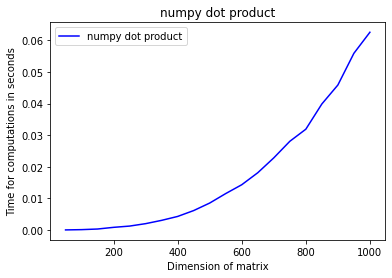

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

x = dim

plt.plot(x,time_dot_prod,'-b',label = 'numpy dot product')
plt.xlabel('Dimension of matrix')
plt.ylabel('Time for computations in seconds')
plt.legend(loc="best")
plt.title('numpy dot product')
plt.show()

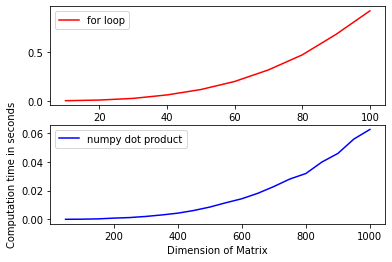

In [ ]:
plt.figure()  # create a plot figure

#create the first of two panels and set current axis
plt.subplot(2, 1, 1) # (rows, columns, panel number)
plt.plot(X,time_for_loop_mini,'-r',label = 'for loop')
#plt.ylabel('Computation time in seconds')
plt.xlabel('Dimension of Matrix')
plt.legend(loc='best')
# create the second panel and set current axis
plt.subplot(2, 1, 2)
plt.plot(x,time_dot_prod,'-b',label = 'numpy dot product') 
plt.ylabel('Computation time in seconds')
plt.xlabel('Dimension of Matrix')
plt.legend(loc='best')
plt.show()

Seeing each functions side by side its clear how much faster numpy dot product is compared to matrix_prod (not the difference in scale on the x-axis). There are several ways that we can improve this. The first thing to note is that numpy automatically stores array elements close to one another in memory which makes them much faster to access. Numpy also uses SIMD techniques to run much of the code in parallel which also provides a significant speed up. First I will use Numba to run part of the code in parallel.

##Numba Just In Time Compliation

Next we will run the same code but using the Numba compiler. It's important to note that this is still serial excercution of the functions and that there is significant space for parallelisation remaining. The dimensional range will now to extended to 1000x1000, in intervals of 50, starting from 50.


The @jit decorator  makes sure that the function "matrix_product_witjit" is just-in-time compiled into fast executable code and then executed. It can be seen from the graph bellow that using numba's JIT compiler is much faster than using GIL, the usual python interpreter. 




In [ ]:
from numba import njit, jit

@jit(nopython=True) #use the just-in-tim compiler for the following function.
def matrix_product_withjit(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b."""
    m = mat_a.shape[0] #Row dim of mat_a
    n = mat_b.shape[1] #Column dim of mat_b

    assert(mat_a.shape[1] == mat_b.shape[0]) #Check rows of mat_a and cols of mat_b have the same dim

    ncol = mat_a.shape[1] #Define col dim of new matrix

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in range(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

time_for_loop_withjit = []


#Record time for for loop with jit compliation.
for i in dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o matrix_product_withjit(a,b)
  time_for_loop_withjit.append(dummy.best) #Add results to the record


The slowest run took 2631.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 154 µs per loop
1000 loops, best of 5: 1.39 ms per loop
100 loops, best of 5: 4.81 ms per loop
100 loops, best of 5: 12.1 ms per loop
10 loops, best of 5: 23 ms per loop
10 loops, best of 5: 40.7 ms per loop
10 loops, best of 5: 66.6 ms per loop
10 loops, best of 5: 103 ms per loop
10 loops, best of 5: 147 ms per loop
1 loop, best of 5: 203 ms per loop
1 loop, best of 5: 275 ms per loop
1 loop, best of 5: 359 ms per loop
1 loop, best of 5: 454 ms per loop
1 loop, best of 5: 568 ms per loop
1 loop, best of 5: 702 ms per loop
1 loop, best of 5: 886 ms per loop
1 loop, best of 5: 994 ms per loop
1 loop, best of 5: 1.21 s per loop
1 loop, best of 5: 1.52 s per loop
1 loop, best of 5: 1.72 s per loop


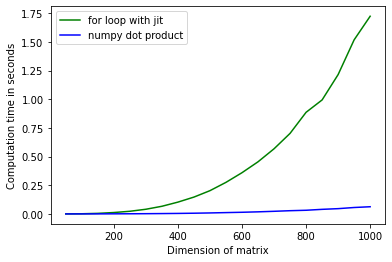

In [ ]:
#Plot the results using matplotlib

x = dim #Define xaxis
y = time_for_loop
w = time_for_loop_withjit #Define variable for the just in time complied nested for loop
z = time_dot_prod #Define variable for the numpy dot product
#plt.plot(x,y,'-r',label = 'for loop computation time')
plt.plot(x,w,'-g',label = 'for loop with jit')
plt.plot(x,z,'-b',label = 'numpy dot product')
plt.xlabel('Dimension of matrix')
plt.ylabel('Computation time in seconds')
plt.legend(loc="best")
plt.show()

With the use of Numba JIT we can compute a matrix product of 750x750 matricies in the same time it would have taken the previous itteration to compute a 100x100 matrix. Using JIT provides an enormouse increase in speed by allowing more efficient computation of the nested for loop by minimising the amount of memory access required in the computation.

##Parallelisation with Numba JIT complier

The goal of parallelisation is to compute multiple parts of the program at the same time. This can be done by splitting up the index set into chunks that can be fed into different threads (different cpu cores) in parallel.

I will attempt to do this with the outter loop of the matrix product function defined in the assessment. This will involve splitting up the computation $C[i,j] = \sum_j A[i,j] * B[j,i]$ over many different chunks of the index variable $i$ (over the outter most loop).

The first step will be to create a worker function that can excercute the desired loop.

There are two important point to note regarding the following code.
First is that the worker is defined within the function inorder to access parameters that are local to the matrix_product_parallel_withjig fucntion.
Second, the only part of the function being run speratly to GIL is the worker which does the actualy calculation.

In [ ]:
@numba.njit(parallel=True)

#Define worker to compute matrix product
def worker(mat_a,mat_b,mat_c,m,n,ncol):
  for row_ind in numba.prange(m): #prange(m) tells us that row_ind is the variable to be split into chunks.
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]
  return mat_c
                    
def matrix_product_parallel_withjit(mat_a, mat_b):
  """Returns the product of the matrices mat_a and mat_b."""
  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b

  assert(mat_a.shape[1] == mat_b.shape[0]) #Check rows of mat_a and cols of mat_b have the same dim

  ncol = mat_a.shape[1] #Define col dim of new matrix

  mat_c = np.zeros((m, n), dtype=np.float64)

  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b
  ncol = mat_a.shape[1]#Define col dim of new matrix
  return worker(mat_a,mat_b,mat_c,m,n,ncol)



parallel_time_for_loop_withjit = []
#Record time for for loop with jit
for i in dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o matrix_product_parallel_withjit(a,b)
  parallel_time_for_loop_withjit.append(dummy.best)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


The slowest run took 5524.46 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 103 µs per loop
1000 loops, best of 5: 825 µs per loop
100 loops, best of 5: 2.72 ms per loop
100 loops, best of 5: 6.79 ms per loop
100 loops, best of 5: 13.7 ms per loop
10 loops, best of 5: 23.9 ms per loop
10 loops, best of 5: 42.4 ms per loop
10 loops, best of 5: 66.9 ms per loop
10 loops, best of 5: 98.6 ms per loop
10 loops, best of 5: 138 ms per loop
10 loops, best of 5: 194 ms per loop
1 loop, best of 5: 210 ms per loop
1 loop, best of 5: 367 ms per loop
1 loop, best of 5: 350 ms per loop
1 loop, best of 5: 1.16 s per loop
1 loop, best of 5: 497 ms per loop
1 loop, best of 5: 737 ms per loop
1 loop, best of 5: 792 ms per loop
1 loop, best of 5: 1.4 s per loop
1 loop, best of 5: 3.76 s per loop


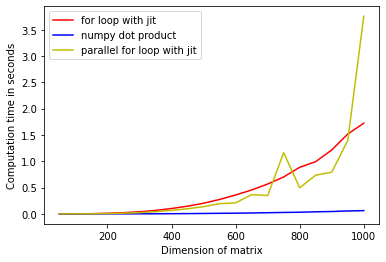

In [ ]:
#Plot the results using matplotlib
x = dim


plt.plot(x,time_for_loop_withjit,'-r',label = 'for loop with jit')
plt.plot(x,time_dot_prod,'-b',label = 'numpy dot product')
plt.plot(x,parallel_time_for_loop_withjit,'-y',label = 'parallel for loop with jit')
plt.xlabel('Dimension of matrix')
plt.ylabel('Computation time in seconds')
plt.legend(loc="best")
plt.show()

As expected, the parallelised code runs faster in general than the series codes, but there are several large jumps to take note off. These are likely due to the way memory is allocated for the processes or due to the small sample size being used. To check this we can adjust how the second matrix is stored in memory. By using fortran style ordering it may be possible in order to improve cache efficiency which will reduce the memory operations needed to compute the matrix product and possibly remove the large jumps on computation time.

#Improve cache by updating the format of matrix B (C_type -> Fortran_type)
The cache is best utilised when we access areas of memory that are local to each other. So stacking data in the order that it will be accessed provides a large speed up because it can be accessed with relativly few memory operations.

In [ ]:
#Set matrix B to fortran data type
@numba.njit(parallel=True)
def worker_b_fortran(mat_a,mat_b,mat_c,m,n,ncol):
  mat_b = np.asfortranarray(mat_b) #Define matrix B as a fortran style array, column major
  for row_ind in numba.prange(m): #We are splitting the row index in multiple chunks
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]
  return mat_c
  
def ft_matrix_product_parallel_withjit(mat_a, mat_b):
  """Returns the product of the matrices mat_a and mat_b."""
  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b

  assert(mat_a.shape[1] == mat_b.shape[0]) #Check rows of mat_a and cols of mat_b have the same dim

  ncol = mat_a.shape[1] #Define col dim of new matrix

  mat_c = np.zeros((m, n), dtype=np.float64)

  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b
  ncol = mat_a.shape[1]#Define col dim of new matrix
  return worker_b_fortran(mat_a,mat_b,mat_c,m,n,ncol)

ft_parallel_time_for_loop_withjit = []
#Record time for for loop with jit
for i in dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o ft_matrix_product_parallel_withjit(a,b)
  ft_parallel_time_for_loop_withjit.append(dummy.best)

The slowest run took 5387.59 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 104 µs per loop
1000 loops, best of 5: 853 µs per loop
100 loops, best of 5: 2.74 ms per loop
100 loops, best of 5: 6.49 ms per loop
100 loops, best of 5: 12.8 ms per loop
10 loops, best of 5: 21.6 ms per loop
10 loops, best of 5: 34.3 ms per loop
10 loops, best of 5: 51.1 ms per loop
10 loops, best of 5: 73 ms per loop
10 loops, best of 5: 99.9 ms per loop
10 loops, best of 5: 132 ms per loop
10 loops, best of 5: 172 ms per loop
1 loop, best of 5: 214 ms per loop
1 loop, best of 5: 266 ms per loop
1 loop, best of 5: 334 ms per loop
1 loop, best of 5: 403 ms per loop
1 loop, best of 5: 484 ms per loop
1 loop, best of 5: 575 ms per loop
1 loop, best of 5: 670 ms per loop
1 loop, best of 5: 783 ms per loop


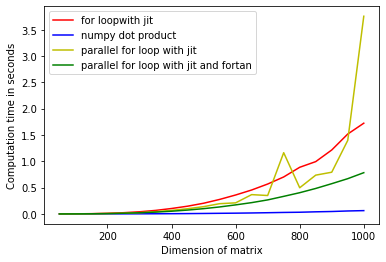

In [ ]:
#Plot the results using matplotlib

plt.plot(x,time_for_loop_withjit,'-r',label = 'for loopwith jit')
plt.plot(x,time_dot_prod,'-b',label = 'numpy dot product')
plt.plot(x,parallel_time_for_loop_withjit,'-y',label = 'parallel for loop with jit')
plt.plot(x,ft_parallel_time_for_loop_withjit,'-g',label = 'parallel for loop with jit and fortan')
plt.xlabel('Dimension of matrix')
plt.ylabel('Computation time in seconds')
plt.legend(loc="best")
plt.show()

We can see that the use of fortran style memory improves the speed of the comutation and removes the large jumps present in the serial and parallel jit compiled for loop implementations of the matrix product. This is likely due to the smooth allocation of memory which results from the fortran style storage.

#Block matrix appoach

We can find matrix elements $c_{\alpha,\beta}$ of $C$ in order of sub matricies $C_{r,q}$. The reason we might try this is to minimise the distance between conscutive pieces of data in the memory. It may lead to an improvement, but the increase overhead of the for loops may be a bit of a bottle neck. To do this we introduce two new indicies, $m$ & $l$ which are the internal indicies for each submatrix. We use the coordinate transforms $\alpha = r \cdot L + m$ and $\beta = q \cdot L + l$ where $r,q$ specify the sub matrix, $m,l$ specify the coordinates with each sub  and $L$ is the dimension of each sub matrix. By iterating over each matrix individually we move much smaller distances in  memory for each operation which may provde a speed up. I will do this using C-style and Fortran-style memory allocation for completeness. Initially I use a block size of L = 50, which splits the multiplication into sub-block of size 50x50. After comparing this to the previous methods I experiment with different block sizes. For simplicity I will only conisder L which are divisors of 50, so that the block will trivially subdivde the larger matrices into integer numbers of lxl blocks.

In [ ]:
#define a worker to compute the computation of C by sub block, using fortran style memory.
@numba.njit(parallel=True)
def block_worker_b_fortran(mat_a,mat_b,mat_c,ncol,L):
  mat_b = np.asfortranarray(mat_b) #Define matrix B as a fortran style array, column major
  R = int(ncol/L)
  for r in numba.prange(R): #We are splitting the row index in multiple chunks
        for q in range(R):
            for m in range(L):
              for l in range(L):
                for k in range(ncol):
                  mat_c[r*L+m, q*L+l] += mat_a[r*L+m, k] * mat_b[k, q*L+l]
  return mat_c

  
def ft_block_matrix_product_parallel_withjit(mat_a, mat_b, l):
  """Returns the product of the matrices mat_a and mat_b."""
  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b

   

  assert(mat_a.shape[1] == mat_b.shape[0]) #Check rows of mat_a and cols of mat_b have the same dim

  ncol = mat_a.shape[1] #Define col dim of new matrix

  mat_c = np.zeros((m, n), dtype=np.float64)

  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b
  ncol = mat_a.shape[1]#Define col dim of new matrix
  return block_worker_b_fortran(mat_a,mat_b,mat_c,ncol,l)

ft_block_matrix_product_parallel_withjit_list = []
#Record time for for loop with block matrix builder using fortan style memory for matrix B.
for i in dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o ft_block_matrix_product_parallel_withjit(a,b,50)
  ft_block_matrix_product_parallel_withjit_list.append(dummy.best)

The slowest run took 4036.87 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 198 µs per loop
1000 loops, best of 5: 856 µs per loop
100 loops, best of 5: 3.55 ms per loop
100 loops, best of 5: 6.9 ms per loop
100 loops, best of 5: 15.3 ms per loop
10 loops, best of 5: 21.6 ms per loop
10 loops, best of 5: 38.9 ms per loop
10 loops, best of 5: 51.2 ms per loop
10 loops, best of 5: 80.2 ms per loop
10 loops, best of 5: 100 ms per loop
10 loops, best of 5: 143 ms per loop
10 loops, best of 5: 172 ms per loop
1 loop, best of 5: 233 ms per loop
1 loop, best of 5: 267 ms per loop
1 loop, best of 5: 351 ms per loop
1 loop, best of 5: 399 ms per loop
1 loop, best of 5: 504 ms per loop
1 loop, best of 5: 565 ms per loop
1 loop, best of 5: 704 ms per loop
1 loop, best of 5: 779 ms per loop


In [ ]:
@numba.njit(parallel=True)
def block_worker_b(mat_a,mat_b,mat_c,ncol,l):
  R = int(ncol/l)
  for r in numba.prange(R): #Tell numba that this loop can be parallelised
        for q in range(R): #Loop over all sub-matricies
            for m in range(l): #Loop over all rows in each sub-matrix
              for L in range(l): #Loop over all columns in each sub-matrix
                for k in range(ncol): #Loop over intermediate variable k in [1...,ncol]
                  mat_c[r*l+m, q*l+L] += mat_a[r*l+m, k] * mat_b[k, q*l+L]
  return mat_c
  
def block_matrix_product_parallel_withjit(mat_a, mat_b, l):
  """Returns the product of the matrices mat_a and mat_b."""
  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b

   

  assert(mat_a.shape[1] == mat_b.shape[0]) #Check rows of mat_a and cols of mat_b have the same dim

  ncol = mat_a.shape[1] #Define col dim of new matrix

  mat_c = np.zeros((m, n), dtype=np.float64)

  m = mat_a.shape[0] #Row dim of mat_a
  n = mat_b.shape[1] #Column dim of mat_b
  ncol = mat_a.shape[1]#Define col dim of new matrix
  return block_worker_b(mat_a,mat_b,mat_c,ncol,l)

block_matrix_product_parallel_withjit_list = []

#Record time for for loop using block matrix worker
for i in dim:
  a = np.random.randn(i, i) #define a randon dimxdim matrix
  b = np.random.randn(i, i) #define a randon dimxdim matrix
  dummy = %timeit -o block_matrix_product_parallel_withjit(a,b,50)
  block_matrix_product_parallel_withjit_list.append(dummy.best)


The slowest run took 4000.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 184 µs per loop
1000 loops, best of 5: 839 µs per loop
100 loops, best of 5: 3.63 ms per loop
100 loops, best of 5: 7.09 ms per loop
100 loops, best of 5: 16.3 ms per loop
10 loops, best of 5: 25.4 ms per loop
10 loops, best of 5: 45.2 ms per loop
10 loops, best of 5: 64.2 ms per loop
10 loops, best of 5: 99.5 ms per loop
10 loops, best of 5: 127 ms per loop
10 loops, best of 5: 180 ms per loop
1 loop, best of 5: 222 ms per loop
1 loop, best of 5: 274 ms per loop
1 loop, best of 5: 522 ms per loop
1 loop, best of 5: 807 ms per loop
1 loop, best of 5: 439 ms per loop
1 loop, best of 5: 1.47 s per loop
1 loop, best of 5: 644 ms per loop
1 loop, best of 5: 1.97 s per loop
The slowest run took 7.69 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 840 ms per loop


Note that in both case we still use the numba compiler, since with using it the overhead required by the for loops completely eliminates all of the benefits  of the block scheme.

Below are the results of the block scheme (with and without fortran style memory) compared to all previous version of the matrix product.

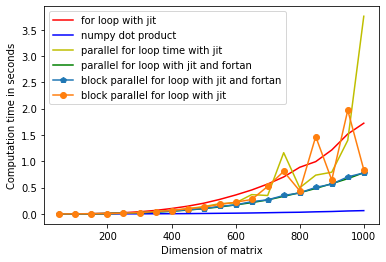

In [ ]:
#Plot the results using matplotlib

plt.plot(x,time_for_loop_withjit,'-r',label = 'for loop with jit')
plt.plot(x,time_dot_prod,'-b',label = 'numpy dot product')
plt.plot(x,parallel_time_for_loop_withjit,'-y',label = 'parallel for loop time with jit')
plt.plot(x,ft_parallel_time_for_loop_withjit,'-g',label = 'parallel for loop with jit and fortan')
plt.plot(x,ft_block_matrix_product_parallel_withjit_list,'-p',label = 'block parallel for loop with jit and fortan')
plt.plot(x,block_matrix_product_parallel_withjit_list,'-o',label = 'block parallel for loop with jit')
plt.xlabel('Dimension of matrix')
plt.ylabel('Computation time in seconds')
plt.legend(loc="best")
plt.show()

The block schemes perform well, in line with the speed up seen using fortran style memory, clearly demonstrating the usefulness of the cache in reducing memory operations. Below I take the log of the block schemes and the for loop based function using parallel jit compilation and fortran style memory (because these are the best three).

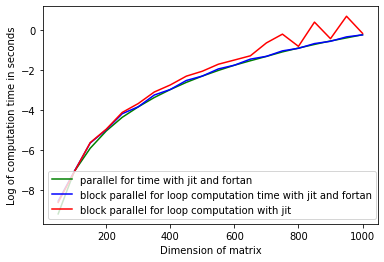

In [ ]:

plt.plot(x,np.log(ft_parallel_time_for_loop_withjit),'-g',label = 'parallel for time with jit and fortan')
plt.plot(x,np.log(ft_block_matrix_product_parallel_withjit_list),'-b',label = 'block parallel for loop computation time with jit and fortan')
plt.plot(x,np.log(block_matrix_product_parallel_withjit_list),'-r',label = 'block parallel for loop computation with jit')
plt.xlabel('Dimension of matrix')
plt.ylabel('Log of computation time in seconds')
plt.legend(loc="best")
plt.show()

We can see that the computation time for the block schemes are very similar to the parallel numba imlementation with fortran style memory, if just slightly slower. Note that the use of fortran style memory with the block matrix worker results in slightly faster computation than without the fortran style memory. Its likely that the overhead of having so many nested for loops counteracts part of the benefit we would see otherwise.

Below I consider different values of L. I only choose values which divide all the chosen matrix dimensions, so that the block will trivially subdive the larger matricies.

In [ ]:
F = [1,5,10,25,50]#These are all the choices of L that subdived dim for all choices of dim between 50 and 1000.
storage_for_all_L = [] #Array to store time values for all dimensions and all choses of L
dummy_array = [] #Array to store intermediate time values for each dimensi
for L in F:
  for i in dim:
    a = np.random.randn(i, i) #define a randon dimxdim matrix
    b = np.random.randn(i, i) #define a randon dimxdim matrix
    dummy = %timeit -n 10 -o block_matrix_product_parallel_withjit(a,b,L)
    dummy_array.append(dummy.best)
  storage_for_all_L.append(dummy_array)

The slowest run took 4.96 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 114 µs per loop
10 loops, best of 5: 853 µs per loop
10 loops, best of 5: 2.83 ms per loop
10 loops, best of 5: 6.85 ms per loop
10 loops, best of 5: 14.7 ms per loop
10 loops, best of 5: 26.5 ms per loop
10 loops, best of 5: 41.3 ms per loop
10 loops, best of 5: 67.7 ms per loop
10 loops, best of 5: 104 ms per loop
10 loops, best of 5: 131 ms per loop
10 loops, best of 5: 197 ms per loop
10 loops, best of 5: 242 ms per loop
10 loops, best of 5: 333 ms per loop
10 loops, best of 5: 472 ms per loop
10 loops, best of 5: 485 ms per loop
10 loops, best of 5: 527 ms per loop
10 loops, best of 5: 722 ms per loop
10 loops, best of 5: 794 ms per loop
10 loops, best of 5: 1.25 s per loop
10 loops, best of 5: 1.01 s per loop
10 loops, best of 5: 107 µs per loop
10 loops, best of 5: 840 µs per loop
10 loops, best of 5: 2.77 ms per loop
10 loops, best of 5: 6.6

In [ ]:

plt.plot(x,Ls[0],label = 'Block size l = 1')
plt.plot(x,Ls[1],label = 'Block size l = 5')
plt.plot(x,Ls[2],label = 'Block size l = 10')
plt.plot(x,Ls[3],label = 'Block size l = 25')
plt.plot(x,Ls[4],label = 'Block size l = 50')
plt.title('Comparison of different sub-block sizes')
plt.ylabel('Computation time in seconds')
plt.ylabel('Dimension of Matrix')
plt.legend(loc = 'best')

NameError: ignored

As the size of the sub block increase from a size of $l=1$ to $l = 50$ the computation size decreases. It seems for certain matrix dimensions there are large irregular jumps, its interesting that these result for all block sizes. These jumps also occur for the other methods of computaion which leads me to beleve that it is a quirk of the way memory is being accessed rather than an issue in the methods used. 